This is a very simple and limited code to generate new sequences with the arDCA model.

# Read alignment and compute frequencies #

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import numpy.matlib
import numpy.linalg as LA
from numpy.linalg import inv

In [2]:
def letter2number(a): 
    #to convert the amino acids letters into integer numbers from 0 to 20
    switcher = {
        '-': 20,
        'A': 0,
        'C': 1,
        'D':2,
        'E':3,
        'F':4,
        'G':5,
        'H':6,
        'I':7,
        'K':8,
        'L':9,
        'M':10,
        'N':11,
        'P':12,
        'Q':13,
        'R':14,
        'S':15,
        'T':16,
        'V':17,
        'W':18,
        'Y':19,     
    }
    return switcher.get(a,0)

def dH(seq1, seq2):
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

In [3]:
# Open the file and write in "seqs" a list containing all lines
data=open('PF00014_mgap6.fasta', 'r')
seqs = data.readlines()[1::2]
data.close()

In [4]:
#Extract L and M and convert the MSA in a numerical matrix
M=np.size(seqs)
L=len(seqs[0])-1
Np=int(L*(L-1)/2)
print(M,L)
align=np.zeros((M,L)).astype(int)
for m in range (M):
    for i in range (L):
        align[m,i]=letter2number(seqs[m][i])  

13600 53


In [7]:
align

array([[20,  1,  9, ...,  6,  1, 20],
       [10,  1, 10, ..., 15,  1, 20],
       [ 0,  1,  8, ..., 14,  1, 20],
       ...,
       [ 0,  1,  9, ...,  0,  1, 20],
       [17,  1, 16, ...,  7,  1, 20],
       [17,  1,  7, ..., 14,  1, 20]])

In [6]:
## possibility to give a file with weights
trainingWeights = np.loadtxt("weights_14") 

#trainingWeights = np.ones(M) # uncomment tghis lign to put uniform weights 

In [8]:
#Expand the alignment in a bynary (M,21xL) array (one-hot encoding)
q=21        
msa=np.zeros((M,L*q))#.astype(int)  
for m in range(M):
    for i in range(L):
        msa[m,i*q+align[m,i]]=1 

#Calculate the 1-point frequencies 
msa_reweighted = np.copy(msa[:M,:])

for i in range(len(msa[:M,1])):
    msa_reweighted[i,:]*= trainingWeights[i]/np.sum(trainingWeights)
p=np.sum(msa_reweighted,0)


In [12]:
msa

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [13]:
#Pseudocount alfa
alfa=0.000001;
pa=(1-alfa)*p+alfa/21.

In [12]:
#Mean field Coupling Matrix
#JMF=-inv(cra)

# Routine with sklearn

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
lreg = LogisticRegression(penalty='l2', tol=0.001, C=1000, fit_intercept=True, intercept_scaling=10, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='multinomial', verbose=0)

In [16]:
#test
i = 1
regsite1 = lreg.fit(msa[0:,:1*q], align[0:,1],sample_weight=trainingWeights)

In [19]:
print(regsite1.score(msa[0:,:1*q], align[0:,1]))
#print(regsite1.coef_.shape)
#print(regsite1.intercept_.shape)

0.9691176470588235


# Sampling and learning

The number of iterations is very small to make the time of learning not too long. For many sites, the learning will stop before the convergence criterion, to change this, increase the number of iterations max_iter, or use the julia code which is much faster.

In [21]:
nb_sample = 10000
sample = np.zeros((nb_sample,L))
site =0
for i in range(nb_sample):
    sample[i,site] =  np.random.choice(np.arange(1,22), 1, p=pa[:q])[0]
for i in range(1,L):
    reg = lreg.fit(msa[0:,:i*q], align[0:,i],sample_weight=trainingWeights)
    classes = reg.classes_
    prob = reg.predict_proba(one_hot_enc(sample[:,:i],nb_sample))
    for j in range(nb_sample):
        sample[j,i] =  np.random.choice(classes+1, 1, p=prob[j,:])[0]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

In [22]:
sample-=1
sample

array([[20.,  1., 13., ..., 15.,  1., 20.],
       [ 0.,  1., 14., ..., 10.,  1.,  3.],
       [ 7.,  1., 10., ...,  0.,  1., 20.],
       ...,
       [20.,  1.,  9., ..., 14.,  1., 20.],
       [17.,  1., 11., ..., 17.,  1., 20.],
       [20.,  1., 16., ..., 16.,  1., 20.]])

In [23]:
align

array([[20,  1,  9, ...,  6,  1, 20],
       [10,  1, 10, ..., 15,  1, 20],
       [ 0,  1,  8, ..., 14,  1, 20],
       ...,
       [ 0,  1,  9, ...,  0,  1, 20],
       [17,  1, 16, ...,  7,  1, 20],
       [17,  1,  7, ..., 14,  1, 20]])

In [24]:
sample_one_hot =np.zeros((nb_sample,L*q))#.astype(int)  
for m in range(nb_sample):
    for i in range(L):
        sample_one_hot[m,i*q+int(sample[m,i])]=1 

# 1-point frequencies

In [26]:
freq_data = np.zeros(q*L)
freq_sample = np.zeros(q*L)
for i in range(q*L):
    #freq_data[i] = np.sum(msa_reweighted[:,i])
    freq_sample[i] = np.sum(sample_one_hot[:,i])/nb_sample

Text(0,0.5,'Sample arDCA')

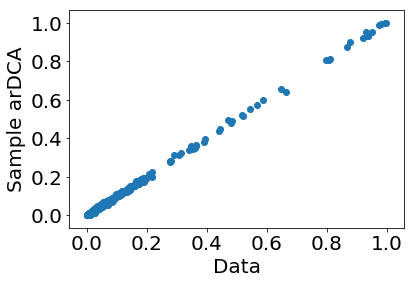

In [61]:
plt.scatter(p,freq_sample)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Data",size = 20)
plt.ylabel("Sample arDCA",size = 20)

# PCA

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(msa[:M,:])

my_cmap = plt.cm.jet

my_cmap.set_under('w',0.01)

In [40]:
X = pca.transform(msa[:M,:])
X2 = pca.transform(sample_one_hot)

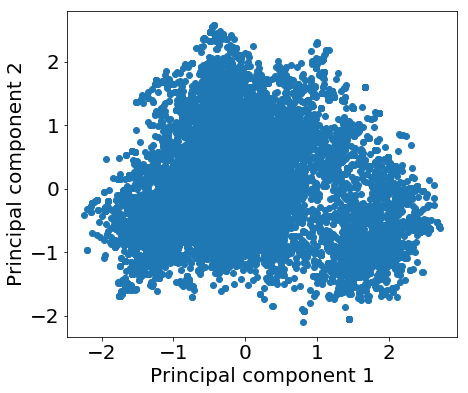

In [58]:
plt.figure(figsize=(7,6))
plt.plot(X[:,0],X[:,1],'o')
plt.xlabel("Principal component 1",size = 20)
plt.ylabel("Principal component 2",size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

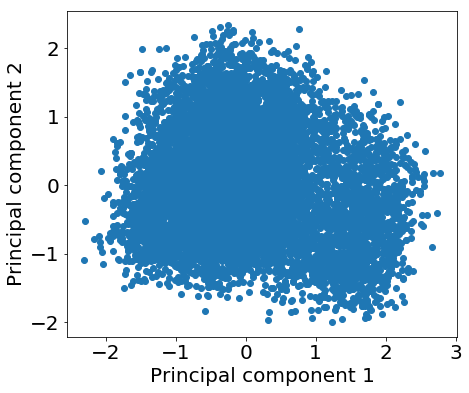

In [57]:
plt.figure(figsize=(7,6))
plt.plot(X2[:,0],X2[:,1],'o')
plt.xlabel("Principal component 1",size = 20)
plt.ylabel("Principal component 2",size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

Can a profile model reproduce the PSA plot?

In [49]:
nb_sample = 10000
sample_pro = np.zeros((nb_sample,L))
site =0
for site in range(L):
    for i in range(nb_sample):
        sample_pro[i,site] =  np.random.choice(np.arange(1,22), 1, p=pa[site*q:(site+1)*q])[0]
    

In [50]:
sample_pro-=1
sample_pro

array([[ 0.,  1., 16., ...,  7.,  1.,  0.],
       [20.,  1., 14., ..., 15.,  1., 20.],
       [ 9.,  1., 16., ..., 16.,  1., 20.],
       ...,
       [20.,  1.,  7., ..., 17.,  1., 20.],
       [20.,  1., 11., ..., 16.,  1., 20.],
       [ 7.,  1., 11., ...,  9.,  1., 14.]])

In [51]:
sample_pro_one_hot =np.zeros((nb_sample,L*q))#.astype(int)  
for m in range(nb_sample):
    for i in range(L):
        sample_pro_one_hot[m,i*q+int(sample_pro[m,i])]=1 

In [52]:
X3 = pca.transform(sample_pro_one_hot)

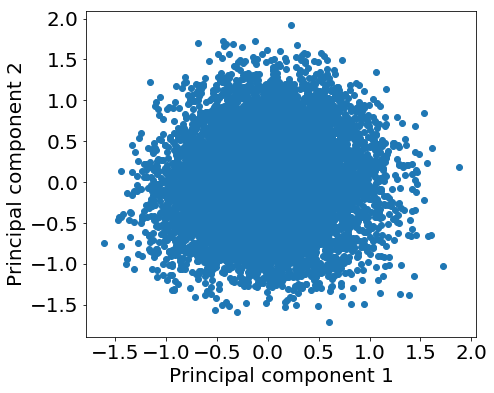

In [55]:
plt.figure(figsize=(7,6))
plt.plot(X3[:,0],X3[:,1],'o')
plt.xlabel("Principal component 1",size = 20)
plt.ylabel("Principal component 2",size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

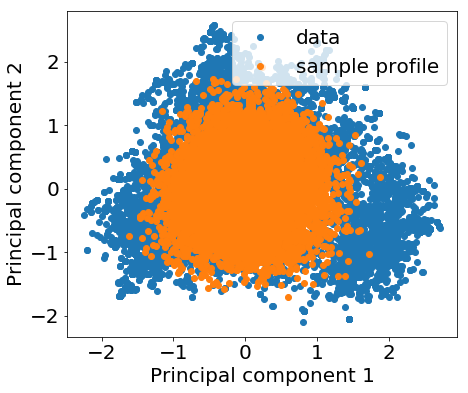

In [59]:
plt.figure(figsize=(7,6))
plt.plot(X[:,0],X[:,1],'o',label = "data")
plt.plot(X3[:,0],X3[:,1],'o',label = "sample profile")
plt.xlabel("Principal component 1",size = 20)
plt.ylabel("Principal component 2",size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(fontsize = 20)
plt.show()

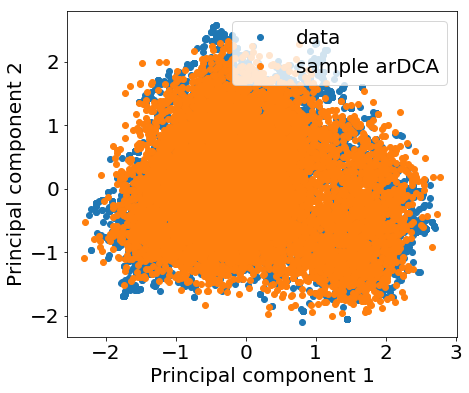

In [60]:
plt.figure(figsize=(7,6))
plt.plot(X[:,0],X[:,1],'o',label = "data")
plt.plot(X2[:,0],X2[:,1],'o',label = "sample arDCA")
plt.xlabel("Principal component 1",size = 20)
plt.ylabel("Principal component 2",size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(fontsize = 20)
plt.show()